<a href="https://colab.research.google.com/github/Sangyeonglee353/ai-musthave/blob/main/Chapter_04_%EC%82%AC%EC%A7%84_%EB%B6%84%EB%A5%98%ED%95%98%EA%B8%B0_CNN%EA%B3%BC_VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4.2 데이터 전처리하기

100%|██████████| 170498071/170498071 [00:06<00:00, 28160749.28it/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


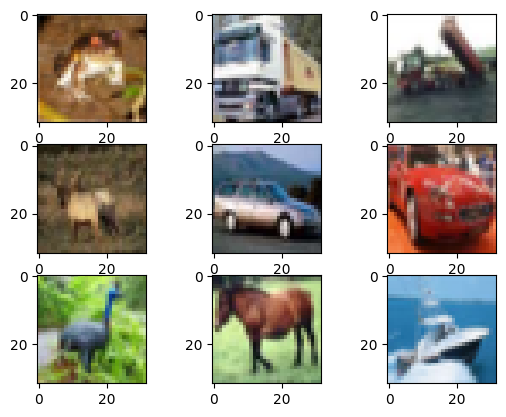

In [2]:
# 데이터 살펴보기
import matplotlib.pyplot as plt

from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import ToTensor

# CIFAR-10 데이터셋 불러오기
training_data = CIFAR10(
    root="./",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = CIFAR10(
    root="./",
    train=False,
    download=True,
    transform=ToTensor()
)

for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.imshow(training_data.data[i])
plt.show()

## 4.2.1 데이터 증강

Files already downloaded and verified
Files already downloaded and verified


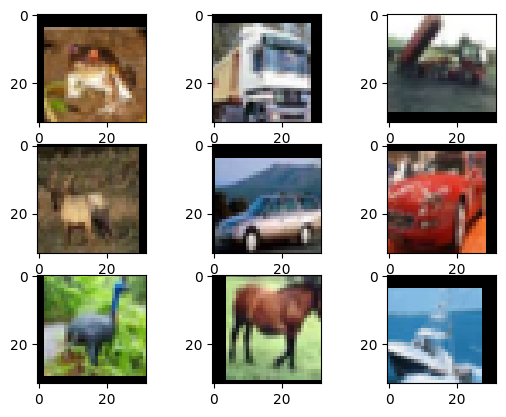

In [4]:
# 데이터 전처리에 크롭핑과 좌우대칭 추가
import matplotlib.pyplot as plt
import torchvision.transforms as T

from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import Compose
from torchvision.transforms import RandomHorizontalFlip, RandomCrop

transforms = Compose([ #1. 데이터 전처리 함수
  T.ToPILImage(),
  RandomCrop((32, 32), padding=4), # 2. 랜덤으로 이미지 일부 제거 후 패딩
  RandomHorizontalFlip(p=0.5), # 3. y축으로 기준으로 대칭
])

training_data = CIFAR10(
    root="./",
    train=True,
    download=True,
    transform=transforms # transform에는 데이터를 변환하는 함수가 들어감
)

test_data = CIFAR10(
    root="./",
    train=False,
    download=True,
    transform=transforms
)

for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.imshow(transforms(training_data.data[i]))
plt.show()

## 4.2.2 이미지 정규화

Files already downloaded and verified
Files already downloaded and verified


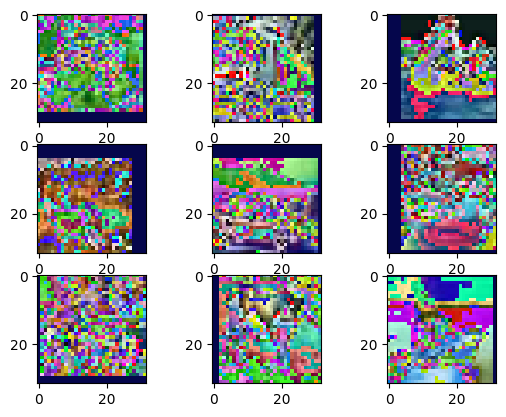

In [6]:
# 데이터 전처리에 정규화 추가
import matplotlib.pyplot as plt
import torchvision.transforms as T

from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import Compose
from torchvision.transforms import RandomHorizontalFlip, RandomCrop, Normalize

# 데이터 전처리 정
transforms = Compose([ #1. 데이터 전처리 함수
  T.ToPILImage(),
  RandomCrop((32, 32), padding=4), # 2. 랜덤으로 이미지 일부 제거 후 패딩
  RandomHorizontalFlip(p=0.5), # 3. y축으로 기준으로 대칭
  T.ToTensor(),

  Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)), # 데이터 정규화
  T.ToPILImage()
])

# 학습용 데이터 정의
training_data = CIFAR10(
    root="./",
    train=True,
    download=True,
    transform=transforms # transform에는 데이터를 변환하는 함수가 들어감
)

# 평가용 데이터 정의
test_data = CIFAR10(
    root="./",
    train=False,
    download=True,
    transform=transforms
)

# 이미지 표시
for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.imshow(transforms(training_data.data[i]))
plt.show()

In [8]:
# 데이터셋의 평균과 표준편차
import torch

training_data = CIFAR10(
    root="./",
    train=True,
    download=True,
    transform=ToTensor()
)

# item[0]은 이미지, item[1]은 정답 레이블
imgs = [item[0] for item in training_data]

# 1. imgs를 하나로 합침
imgs = torch.stack(imgs, dim=0).numpy()

# rgb 각 평균
mean_r = imgs[:, 0, :, :].mean()
mean_g = imgs[:, 1, :, :].mean()
mean_b = imgs[:, 2, :, :].mean()
print(mean_r, mean_g, mean_b)

# rgb 각 표준편차
std_r = imgs[:,0,:,:].std()
std_g = imgs[:,1,:,:].std()
std_b = imgs[:,2,:,:].std()
print(std_r, std_g, std_b)

Files already downloaded and verified
0.49139968 0.48215827 0.44653124
0.24703233 0.24348505 0.26158768


# 4.3 CNN으로 이미지 분류하기

## 4.3.1 기본 블록 정의하기

In [9]:
# VGG 기본 블록 정의
import torch
import torch.nn as nn

class BasicBlock(nn.Module): # 1. 기본 블록 정의
  # 기본 블록을 구성하는 층 정의
  def __init__(self, in_channels, out_channels, hidden_dim):
    # 2. nn.Module 클래스의 요소 상속
    super(BasicBlock, self).__init__()
    # 3. 합성곱층 정의
    self.conv1 = nn.Conv2d(in_channels, hidden_dim, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(in_channels, hidden_dim, kernel_size=3, padding=1)
    self.relu = nn.ReLU()

    # stride는 커널의 이동 거리
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

  def forward(self, x): # 4. 기본 블록의 순전파 정의
    x = self.conv1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.relu(x)
    x = self.pool(x)

    return x

## 4.3.2 CNN 모델 정의하기

In [10]:
# VGG 모델 정의하기
class CNN(nn.Module):
  def __init__(self, num_classes): # num_classes는 클래스 개수
    super(CNN, self).__init__()

    # 1. 합성곱 기본 블록 정의
    self.block1 = BasicBlock(in_channels=3, out_channels=32, hidden_dim=16)
    self.block2 = BasicBlock(in_channels=32, out_channels=128, hidden_dim=64)
    self.block3 = BasicBlock(in_channels=128, out_channels=256, hidden_dim=128)

    # 2. 분류기 정의
    self.fc1 = nn.Linear(in_features=4096, out_features=2048)
    self.fc2 = nn.Linear(in_features=2048, out_features=256)
    self.fc3 = nn.Linear(in_features=256, out_features=num_classes)

    # 3. 분류기의 활성화 함수
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x) # 출력 모양: (-1, 256, 4, 4)
    x = torch.flatten(x, start_dim=1) # 4. 2차원 특징 맵을 1차원으로

    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    x = self.relu(x)
    x = self.fc(3)

    return x


## 4.3.3 모델 학습하기

In [11]:
# 데이터 증강 정의
from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam

transforms = Compose([
    RandomCrop((32, 32), padding=4), # 1. 랜덤 크롭핑
    RandomHorizontalFlip(p=0.5), # 2. y축으로 좌우대칭
    ToTensor(), # 3. 텐서로 변환

    # 4. 이미지 정규화
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
])

In [12]:
# 데이터 로드 및 모델 정의
# 1. 학습용 데이터와 평가용 데이터 불러오기
training_data = CIFAR10(root="./", train=True, download=True, transform=transforms)
test_data = CIFAR10(root="./", train=False, download=True, transform=transforms)

# 2. 데이터로더 정의
train_loader = DataLoader(training_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# 3. 학습을 진행할 프로세서 설정
device = "cuda" if torch.cuda.is_available() else "cpu"

# 4. CNN 모델 정의
model = CNN(num_classes=10)

# 5. 모델을 device로 보냄
model.to(device)

Files already downloaded and verified
Files already downloaded and verified


CNN(
  (block1): BasicBlock(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): BasicBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=4096, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=256, b

In [18]:
# 모델 학습하기
# 1. 학습률 정의
lr = 1e-3

# 2. 최적화 기법 정의
optim = Adam(model.parameters(), lr=lr)

# 학습 루프 정의
for epoch in range(100):
  for data, label in train_loader: # 3. 데이터 호출
    optim.zero_grad() # 4. 기울기 초기화

    preds = model(data.to(device)) # 5. 모델의 예측

    # 6. 오차역전파와 최적화
    loss = nn.CrossEntropyLoss()(preds, label.to(device))
    loss.backward()
    optim.step()

  if epoch==0 or epoch%10==9: # 10번마다 손실 출력
    print(f"epoch{epoch+1} loss:{loss.item()}")

# 모델 저장
torch.save(model.state_dict(), "CIFAR.pth")

RuntimeError: Given groups=1, weight of size [16, 3, 3, 3], expected input[32, 16, 32, 32] to have 3 channels, but got 16 channels instead

## 4.3.4 모델 성능 평가하기

In [17]:
# 모델 성능 확인
model.load_state_dict(torch.load("CIFAR.pth", map_location=device))

num_corr = 0

with torch.no_grad():
  for data, label in test_loader:
    ouput = model(data.to(device))
    preds = output.data.max(1)[1]
    corr = preds.eq(label.to(device).data).sum().item()
    num_corr += corr

  print(f"Accuracy:{num_corr/len(test_data)}")

FileNotFoundError: [Errno 2] No such file or directory: 'CIFAR.pth'

# 4.4 전이 학습 모델 VGG로 분류하기